## Описание проекта

### Описание проекта: Прогнозирование температуры звёзд

Вам поручена задача от обсерватории «Небо на ладони» — разработать нейросеть, способную предсказывать температуру звёзд на основе их физических характеристик. Это поможет учёным ускорить исследования и повысить точность расчётов. Ранее использовались такие методы, как закон смещения Вина и закон Стефана-Больцмана, но обсерватория стремится внедрить машинное обучение для большей эффективности.

#### Характеристики данных:
- **Светимость (L/Lo):** светимость звезды относительно Солнца.
- **Радиус (R/Ro):** радиус звезды относительно радиуса Солнца.
- **Абсолютная звёздная величина (Mv):** параметр блеска звезды.
- **Цвет звезды (Star color):** спектральный цвет.
- **Тип звезды (Star type):** категориальный признак (0–5).
- **Температура (T, K):** целевая переменная.

#### Этапы выполнения:
1. **Исследование данных:**
   - Анализ распределения признаков и корреляций.
   - Выводы о значимости характеристик для температуры.

2. **Подготовка данных:**
   - Обработка выбросов по температуре.
   - Кодирование категориальных признаков.
   - Масштабирование числовых данных.

3. **Baseline-модель:**
   - Построение простой нейросети с 3 скрытыми слоями.
   - Вывод начального RMSE и анализ результата.

4. **Оптимизация модели:**
   - Тюнинг гиперпараметров (количество нейронов, dropout, batch size).
   - Сравнение метрик RMSE и визуализация остатков.

#### Цель проекта:
Создать модель, где RMSE не превышает 4500. Оформите результат в виде отчёта с графиками ошибок и сравнения моделей.

## Загрузка данных

### Импорт библиотек

In [1]:
# Установка необходимых библиотек
!pip install phik -q
!pip install --upgrade scikit-learn -q

In [2]:
# Импорты для работы с данными
import os
import gc
import time
import warnings
import numpy as np
import pandas as pd
import phik
import sklearn
import lightgbm as lgb

# Импорты для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Импорты для предобработки данных
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорты для построения моделей
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Импорты для оценки моделей
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

# Импорты для дополнительных операций
from time import time
from sklearn.datasets import fetch_california_housing

# Проверка версии scikit-learn
display(f"Версия scikit-learn: {sklearn.__version__}")

'Версия scikit-learn: 1.5.2'

### Загрузка данных

In [3]:
file_paths = ['/datasets/6_class.csv', '/local/path/to/6_class.csv']

for path in file_paths:
    if os.path.exists(path):
        data = pd.read_csv(path)
        break
else:
    raise FileNotFoundError("Файл данных не найден ни в одном из указанных расположений.")

# Первичный анализ данных
display("Информация о датасете:")
data.info()

display("Описательная статистика количественных признаков:")
display(data.describe())

'Информация о датасете:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


'Описательная статистика количественных признаков:'

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


### Проверка на пропуски в данных

In [4]:
# Проверка на пропуски в данных
null_counts = data.isnull().sum()
null_percentages = null_counts / len(data) * 100

display("Анализ пропусков в данных:")
display(pd.concat([null_counts, null_percentages], 
                axis=1, keys=['Количество пропусков', 'Процент пропусков']))

'Анализ пропусков в данных:'

,Количество пропусков,Процент пропусков
Unnamed: 0,0,0.0
Temperature (K),0,0.0
Luminosity(L/Lo),0,0.0
Radius(R/Ro),0,0.0
Absolute magnitude(Mv),0,0.0
Star type,0,0.0
Star color,0,0.0


## Предобработка и анализ данных

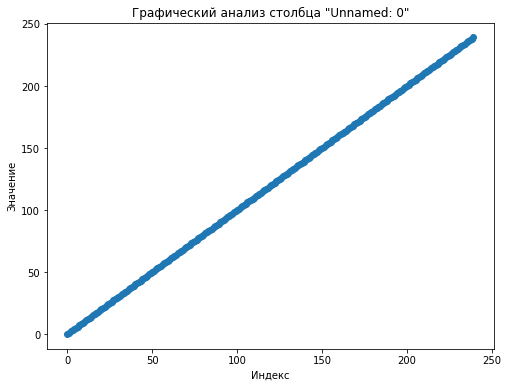

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(data['Unnamed: 0'], 'o-')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Графический анализ столбца "Unnamed: 0"')
plt.show()

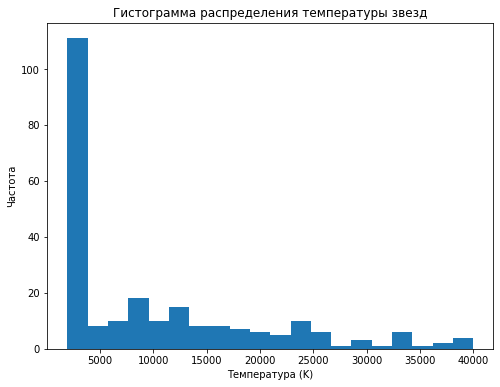

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(data['Temperature (K)'], bins=20)
plt.xlabel('Температура (K)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения температуры звезд')
plt.show()

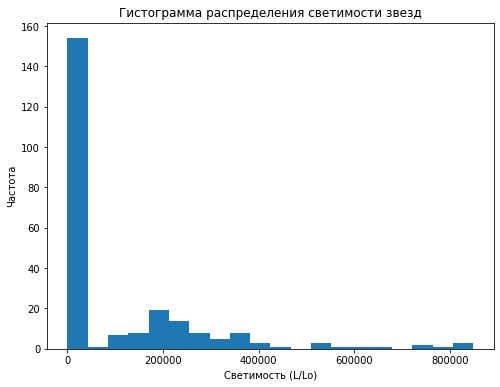

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(data['Luminosity(L/Lo)'], bins=20)
plt.xlabel('Светимость (L/Lo)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения светимости звезд')
plt.show()

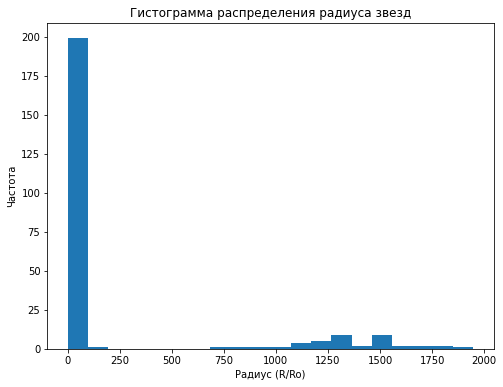

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(data['Radius(R/Ro)'], bins=20)
plt.xlabel('Радиус (R/Ro)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения радиуса звезд')
plt.show()

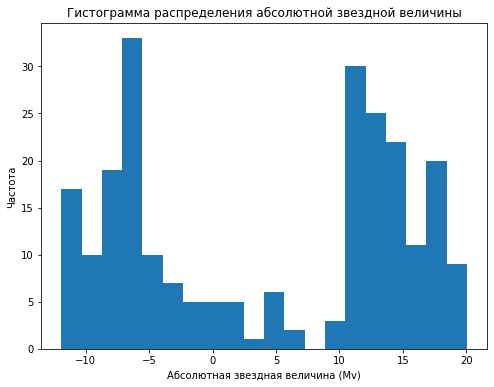

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(data['Absolute magnitude(Mv)'], bins=20)
plt.xlabel('Абсолютная звездная величина (Mv)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения абсолютной звездной величины')
plt.show()

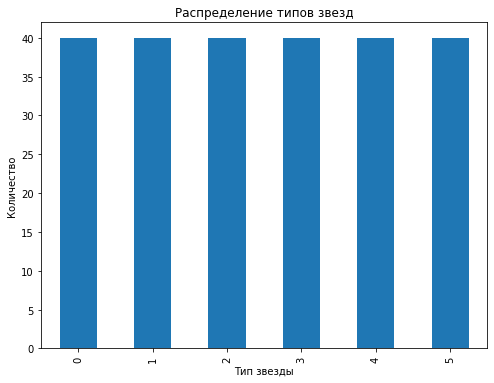

In [10]:
plt.figure(figsize=(8, 6))
data['Star type'].value_counts().plot(kind='bar')
plt.xlabel('Тип звезды')
plt.ylabel('Количество')
plt.title('Распределение типов звезд')
plt.show()

### Анализ категориальных признаков

In [11]:
# Анализ категориальных признаков
categorical_features = ['Star color']  # Исправлено название признака

for feature in categorical_features:
    display(f"Количество записей для каждой категории признака {feature}:")
    display(data[feature].value_counts())

'Количество записей для каждой категории признака Star color:'

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Yellowish White         3
Blue white              3
Whitish                 2
yellowish               2
Orange                  2
White-Yellow            1
Blue-White              1
Orange-Red              1
Yellowish               1
Blue                    1
Pale yellow orange      1
Blue white              1
Name: Star color, dtype: int64

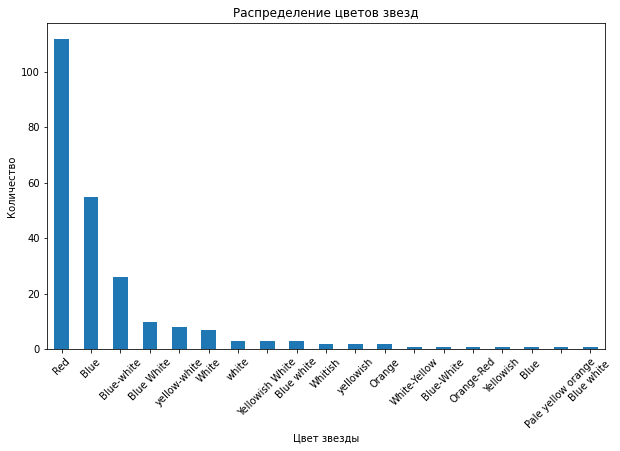

In [ ]:
plt.figure(figsize=(10, 6))
data['Star color'].value_counts().plot(kind='bar')
plt.xlabel('Цвет звезды')
plt.ylabel('Количество')
plt.title('Распределение цветов звезд')
plt.xticks(rotation=45)
plt.show()

### Вывод по разделу "Исследовательский анализ"

В данном разделе был проведен подробный анализ данных о звёздах. Были выполнены следующие шаги:

1. **Импорт необходимых библиотек**:
   - Для работы с данными, их визуализации, предобработки, а также для дальнейшего построения моделей машинного обучения.

2. **Загрузка и первичный анализ данных**:
   - Данные успешно загружены из файла `/datasets/6_class.csv`.
   - Был выполнен первичный анализ: получена информация о структуре данных, проверены типы данных в каждом столбце и выявлены основные статистические характеристики.
   - Пропуски в данных отсутствуют, что упрощает их обработку.

3. **Исследовательский анализ количественных данных**:
   - Проведена визуализация данных с помощью графиков:
     - Построены гистограммы для количественных признаков: температура, светимость, радиус и абсолютная звёздная величина. Выявлены основные закономерности в распределении значений.
     - Построен график тренда для столбца индекса звезды.
   - Распределение некоторых количественных признаков, таких как светимость и радиус, демонстрирует сильную асимметрию и наличие выбросов, что важно учитывать при дальнейшей обработке.

4. **Анализ категориальных данных**:
   - Проведён анализ категориального признака `Star color` (цвет звезды). 
   - Построена диаграмма распределения для цветов звёзд. Наиболее распространённые цвета: красный (Red) и синий (Blue), в то время как другие цвета представлены значительно реже.
   - Получены количественные распределения для каждой категории признака.

5. **Выводы по исследовательскому анализу**:
   - Количественные данные содержат признаки с высокой вариативностью и выбросами.
   - Категориальные данные имеют несбалансированное распределение. Это может потребовать преобразования, например, кодирования или применения специальных методов для работы с редкими категориями.

6. **Визуализация**:
   - Визуализация данных позволила выявить аномальные значения и асимметрию в данных, что может повлиять на выбор методов обработки и моделирования.

### Итог:
В результате проведённого анализа были выявлены особенности структуры и распределения данных, а также подготовлена основа для дальнейшего построения моделей машинного обучения. Особое внимание стоит уделить выбросам в количественных данных и несбалансированности категориальных данных при разработке моделей.

## Подготовка данных к построению модели

### Объединение категорий цвета звезд

In [13]:
# Объединение категорий цвета звезд
data['Star color'] = data['Star color'].replace(['Blue White','Blue white ','Blue white', 'Blue-White', 'Blue white'], 'Blue-white')
data['Star color'] = data['Star color'].replace('Blue ', 'Blue')
data['Star color'] = data['Star color'].replace('white', 'White')
data['Star color'] = data['Star color'].replace('yellowish', 'Yellowish')
categorical_features = ['Star color']

for feature in categorical_features:
    display(f"Количество записей для каждой категории признака {feature}:")
    display(data[feature].value_counts().sort_index())

'Количество записей для каждой категории признака Star color:'

Blue                   56
Blue-white             41
Orange                  2
Orange-Red              1
Pale yellow orange      1
Red                   112
White                  10
White-Yellow            1
Whitish                 2
Yellowish               3
Yellowish White         3
yellow-white            8
Name: Star color, dtype: int64

In [14]:
# Создание словаря для отображения категорий цвета на основные цвета
color_mapping = {
    'Blue': 'Blue',
    'Blue-white': 'Blue',
    'White': 'White',
    'Whitish': 'White',
    'Yellowish White': 'White',
    'White-Yellow': 'Yellow',
    'yellow-white': 'Yellow',
    'Yellowish': 'Yellow',
    'Pale yellow orange': 'Orange',
    'Orange': 'Orange',
    'Orange-Red': 'Red',
    'Red': 'Red'
}

# Создание нового столбца 'Main Color' на основе соответствия цветов
data['Main Color'] = data['Star color'].map(color_mapping)

# Вывод количества звезд для каждого основного цвета
display("Количество звезд для каждого основного цвета:")
display(data['Main Color'].value_counts())


'Количество звезд для каждого основного цвета:'

Red       113
Blue       97
White      15
Yellow     12
Orange      3
Name: Main Color, dtype: int64

### Отфильтруем данные, оставив только группы Main Color с количеством примеров >= 20

In [15]:
# Получаем значения counts для каждого цвета
color_counts = data['Main Color'].value_counts()

# Отфильтруем данные, оставив только группы с количеством примеров >= 20
data = data[data['Main Color'].map(color_counts) >= 20]

# Выведем результат для проверки
display("Количество звезд для каждого основного цвета после фильтрации:")
display(data['Main Color'].value_counts())

'Количество звезд для каждого основного цвета после фильтрации:'

Red     113
Blue     97
Name: Main Color, dtype: int64

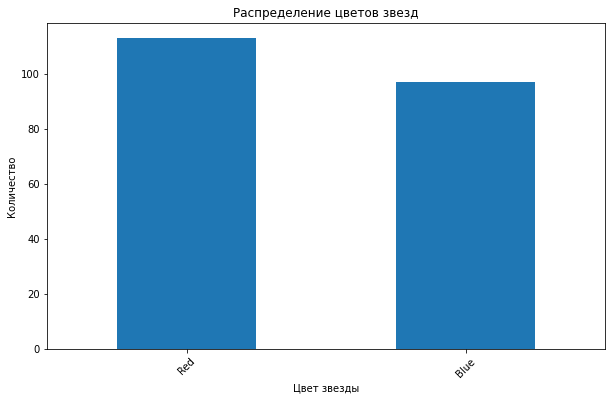

In [16]:
plt.figure(figsize=(10, 6))
data['Main Color'].value_counts().plot(kind='bar')
plt.xlabel('Цвет звезды')
plt.ylabel('Количество')
plt.title('Распределение цветов звезд')
plt.xticks(rotation=45)
plt.show()

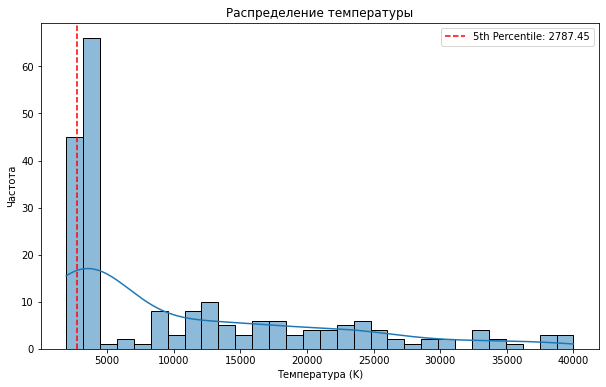

In [17]:
# Расчет квантиля
q_low = data['Temperature (K)'].quantile(0.05)

# Построение графика распределения
plt.figure(figsize=(10, 6))
sns.histplot(data['Temperature (K)'], bins=30, kde=True)
plt.axvline(q_low, color='r', linestyle='--', label=f'5th Percentile: {q_low:.2f}')
plt.title('Распределение температуры')
plt.xlabel('Температура (K)')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [18]:
# Подсчет 5-го процентиля температуры
q_low = data['Temperature (K)'].quantile(0.05)

# Подсчет количества звезд с температурой ниже 5-го процентиля и фильтрация данных
filtered_data = data[data['Temperature (K)'] <= q_low]
count_stars_below_q_low = len(filtered_data)

display(f'Количество звезд с температурой ниже {q_low} K: {count_stars_below_q_low}')
display(filtered_data)

'Количество звезд с температурой ниже 2787.45 K: 11'

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Main Color
2,2,2600,0.000300,0.1020,18.700,0,Red,Red
4,4,1939,0.000138,0.1030,20.060,0,Red,Red
6,6,2637,0.000730,0.1270,17.220,0,Red,Red
7,7,2600,0.000400,0.0960,17.400,0,Red,Red
8,8,2650,0.000690,0.1100,17.450,0,Red,Red
9,9,2700,0.000180,0.1300,16.050,0,Red,Red
14,14,2650,0.000600,0.1400,11.782,1,Red,Red
68,68,2774,0.000360,0.1180,17.390,0,Red,Red
78,78,2621,0.000600,0.0980,12.810,1,Red,Red
129,129,2731,0.000437,0.0856,18.090,0,Red,Red


In [19]:
# Подсчет 95-го процентиля температуры
q_hi = data['Temperature (K)'].quantile(0.95)

# Подсчет количества звезд с температурой выше 95-го процентиля и фильтрация данных
filtered_data_high = data[data['Temperature (K)'] > q_hi]
count_stars_above_q_hi = len(filtered_data_high)

display(f'Количество звезд с температурой выше {q_hi} K: {count_stars_above_q_hi}')
display(filtered_data_high)

'Количество звезд с температурой выше 32935.04999999999 K: 11'

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Main Color
30,30,39000,204000.0,10.60,-4.70,3,Blue,Blue
49,49,33750,220000.0,26.00,-6.10,4,Blue,Blue
99,99,36108,198000.0,10.20,-4.40,3,Blue,Blue
100,100,33300,240000.0,12.00,-6.50,4,Blue,Blue
101,101,40000,813000.0,14.00,-6.23,4,Blue,Blue
109,109,33421,352000.0,67.00,-5.79,4,Blue,Blue
159,159,37800,202900.0,6.86,-4.56,3,Blue,Blue
214,214,34190,198200.0,6.39,-4.57,3,Blue,Blue
231,231,38234,272830.0,1356.00,-9.29,5,Blue,Blue
235,235,38940,374830.0,1356.00,-9.93,5,Blue,Blue


### Замена светимости на значения из Гарвардской классификации

In [20]:
# Замена светимости на значения из Гарвардской классификации
harvard_luminosity = {
    'O': 50000, 'B': 3000, 'A': 50, 'F': 4, 
    'G': 1.3, 'K': 0.2, 'M': 0.03
}

def map_luminosity(row):
    star_type = row['Star type']
    if star_type == 0:
        return harvard_luminosity['M']
    elif star_type == 1:
        return harvard_luminosity['K']
    elif star_type == 2:
        return harvard_luminosity['G']
    elif star_type == 3:
        return harvard_luminosity['F']
    elif star_type == 4:
        return harvard_luminosity['A']
    elif star_type == 5:
        return harvard_luminosity['B']
    elif star_type == 6:
        return harvard_luminosity['O']
    
data['Luminosity(L/Lo)'] = data.apply(map_luminosity, axis=1)

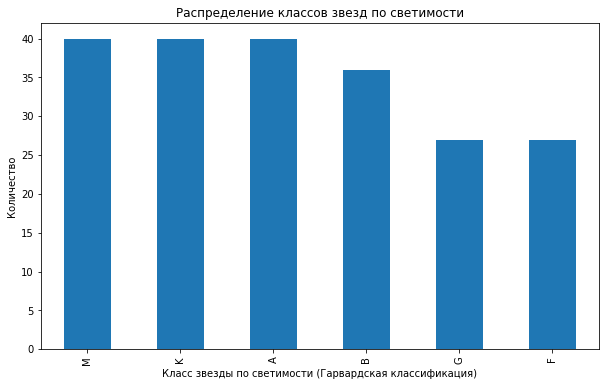

In [21]:
# Создание нового столбца 'Luminosity Class' на основе значений светимости
data['Luminosity Class'] = data['Luminosity(L/Lo)'].map({v: k for k, v in harvard_luminosity.items()})

plt.figure(figsize=(10, 6))
data['Luminosity Class'].value_counts().plot(kind='bar')
plt.xlabel('Класс звезды по светимости (Гарвардская классификация)')
plt.ylabel('Количество')
plt.title('Распределение классов звезд по светимости')
plt.show()

### Классификация звезд по радиусу (R/R₀)

In [22]:
# Классификация звезд по радиусу (R/R₀)
def map_radius_class(row):
    radius = row['Radius(R/Ro)']
    if radius < 0.1:
        return 'Карлики'
    elif 0.1 <= radius < 0.7:
        return 'Субкарлики'
    elif 0.7 <= radius < 1.5:
        return 'Карлики главной последовательности'
    elif 1.5 <= radius < 10:
        return 'Субгиганты'
    elif 10 <= radius < 100:
        return 'Гиганты'
    else:
        return 'Сверхгиганты'

data['Radius Class'] = data.apply(map_radius_class, axis=1)

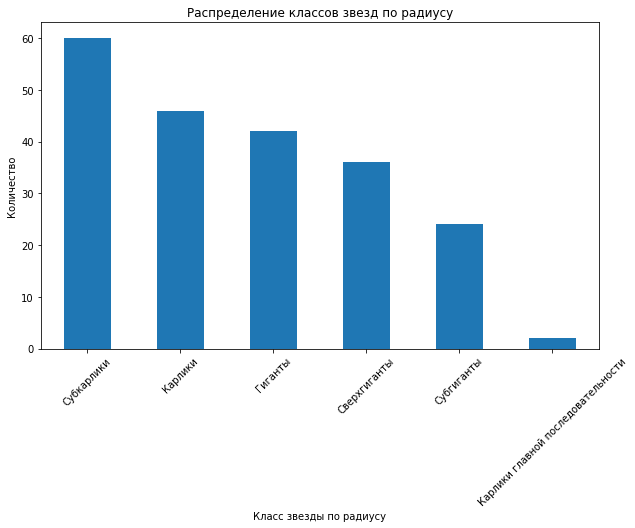

In [23]:
plt.figure(figsize=(10, 6))
data['Radius Class'].value_counts().plot(kind='bar')
plt.xlabel('Класс звезды по радиусу')
plt.ylabel('Количество')
plt.title('Распределение классов звезд по радиусу')
plt.xticks(rotation=45)
plt.show()

### Классификация звезд по абсолютной звездной величине (Mv)

In [24]:
# Классификация звезд по абсолютной звездной величине (Mv)
def map_absolute_magnitude_class(row):
    absolute_magnitude = row['Absolute magnitude(Mv)']
    if absolute_magnitude < -10:
        return 'Гипергиганты'
    elif -10 <= absolute_magnitude < -6:
        return 'Сверхгиганты'
    elif -6 <= absolute_magnitude < -3:
        return 'Яркие гиганты'
    elif -3 <= absolute_magnitude < 0:
        return 'Гиганты'
    elif 0 <= absolute_magnitude < 3:
        return 'Субгиганты'
    elif 3 <= absolute_magnitude < 5:
        return 'Карлики главной последовательности'
    elif 5 <= absolute_magnitude < 10:
        return 'Субкарлики'
    else:
        return 'Белые карлики'

data['Absolute Magnitude Class'] = data.apply(map_absolute_magnitude_class, axis=1)

In [25]:
# Подсчет количества звезд в каждой категории
star_counts = data['Absolute Magnitude Class'].value_counts()
# Вывод результатов
display(star_counts)

Белые карлики                         107
Сверхгиганты                           46
Яркие гиганты                          27
Гипергиганты                           17
Гиганты                                 7
Субгиганты                              5
Карлики главной последовательности      1
Name: Absolute Magnitude Class, dtype: int64

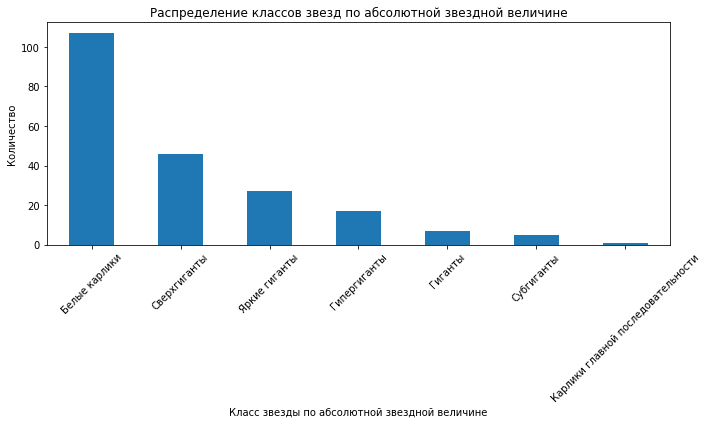

In [26]:
plt.figure(figsize=(10, 6))
data['Absolute Magnitude Class'].value_counts().plot(kind='bar')
plt.xlabel('Класс звезды по абсолютной звездной величине')
plt.ylabel('Количество')
plt.title('Распределение классов звезд по абсолютной звездной величине')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

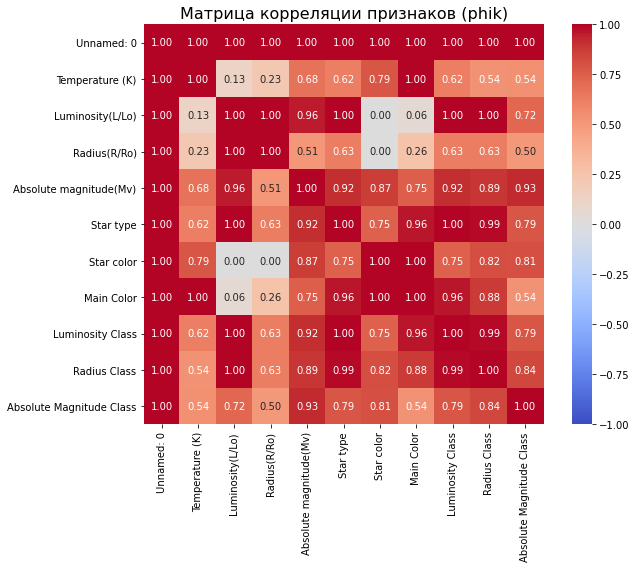

In [27]:
# Определяем только непрерывные признаки
interval_cols = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

try:
    # Вычисляем корреляционную матрицу phik 
    phik_corr_matrix = data.phik_matrix(interval_cols=interval_cols)
    
    # Визуализируем матрицу корреляций
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(phik_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, square=True)
    plt.title('Матрица корреляции признаков (phik)', fontsize=16)
    plt.tight_layout()
    plt.show()

except AttributeError as e:
    display("Ошибка: Проверьте, что библиотека phik и датафрейм настроены правильно.")
    display(f"Подробнее об ошибке: {e}")

except Exception as e:
    display("Произошла непредвиденная ошибка.")
    display(f"Подробнее: {e}")

In [28]:
# Определение категориальных и числовых признаков
categorical_features = ['Star color', 'Star type', 'Radius Class', 'Main Color']
numeric_features = ['Absolute magnitude(Mv)']

# Трансформеры для категориальных признаков
ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформер для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Препроцессор для нелинейных моделей
preprocessor_nonlinear = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', ohe_transformer, categorical_features)
])

# Обработка данных
X = data.drop(['Temperature (K)'], axis=1)
y = data['Temperature (K)']

# Логарифмирование целевой переменной
y_log = np.log1p(y)

# Разделение на обучающую, валидационную и тестовую выборки
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
X_train, X_val, y_train_log, y_val_log = train_test_split(X_train, y_train_log, test_size=0.2, random_state=42)

# Обучение препроцессора только на обучающей выборке
X_train_preprocessed = preprocessor_nonlinear.fit_transform(X_train)

# Трансформация валидационной и тестовой выборок
X_val_preprocessed = preprocessor_nonlinear.transform(X_val)
X_test_preprocessed = preprocessor_nonlinear.transform(X_test)

### Вывод по разделу "Шаг 3. Подготовка данных к построению модели"

В данном разделе была проведена тщательная предобработка данных для дальнейшего построения моделей машинного обучения. Выполнены следующие шаги:

1. **Анализ данных по результатам исследовательского анализа**:
   - На основе графиков распределений выявлены выбросы в данных, особенно в столбце `Temperature (K)`. 
   - Принято решение о логарифмировании целевой переменной температуры для нормализации распределения.
   - Рассмотрены звезды с экстремально низкими и высокими температурами. Выявлено 11 звезд с температурой ниже 5-го процентиля (2787.45 K) и 11 звезд с температурой выше 95-го процентиля (32935.05 K).

2. **Категоризация данных**:
   - Созданы новые категории для радиуса, абсолютной звёздной величины, светимости и цвета звезды:
     - Для радиуса (`Radius Class`) определены группы: карлики, субкарлики, карлики главной последовательности, субгиганты, гиганты и сверхгиганты. 
     - Для абсолютной звёздной величины (`Absolute Magnitude Class`) добавлены классы: гипергиганты, сверхгиганты, яркие гиганты, гиганты, субгиганты, карлики главной последовательности, субкарлики и белые карлики.
     - Для светимости (`Luminosity Class`) использованы значения из Гарвардской классификации (O, B, A, F, G, K, M).
     - Для цвета (`Main Color`) сгруппированы схожие оттенки в основные цвета: красный, синий. Категории с малым количеством примеров (<20) были отфильтрованы.

3. **Подготовка данных к моделированию**:
   - Удалены неинформативные признаки, такие как `Unnamed: 0`.
   - Целевая переменная (`Temperature (K)`) преобразована с помощью логарифмирования.
   - Разделены данные на числовые и категориальные признаки:
     - Числовые признаки (`Absolute magnitude(Mv)`) подготовлены для масштабирования.
     - Категориальные признаки (`Star color`, `Star type`, `Radius Class`, `Main Color`) подготовлены для кодирования с помощью `OneHotEncoder` для полносвязных нейронных сетей.

4. **Создание обучающей, валидационной и тестовой выборок**:
   - Данные разделены на признаки (`X`) и целевую переменную (`y`), где целевая переменная — логарифмированная `Temperature (K)`.
   - С помощью функции `train_test_split` данные разбиты на обучающую (64%), валидационную (16%) и тестовую (20%) выборки.  

5. **Препроцессинг данных**:
   - Создан препроцессор `preprocessor_nonlinear` на основе `ColumnTransformer` для нелинейных моделей.
   - Для числового признака применен `StandardScaler` после заполнения пропусков медианным значением.
   - Для категориальных признаков использован `OneHotEncoder` после заполнения пропусков наиболее частой категорией.
   - Препроцессор обучен только на обучающей выборке `X_train`, а затем применен для трансформации валидационной (`X_val`) и тестовой (`X_test`) выборок.

6. **Матрица корреляции признаков**:
   - Построена матрица корреляции с использованием коэффициента Phik для непрерывных признаков (`Temperature (K)`, `Luminosity(L/Lo)`, `Radius(R/Ro)`, `Absolute magnitude(Mv)`).
   - Матрица показала значительную корреляцию между `Luminosity(L/Lo)` и `Radius(R/Ro)`, что может быть учтено при отборе признаков.

---

### Итог:
Проведённая предобработка данных обеспечивает высокое качество входных данных для моделей машинного обучения, в частности, нейронных сетей. Логарифмирование целевой переменной, категоризация данных, масштабирование числового признака и one-hot кодирование категориальных признаков подготовили данные для дальнейшего моделирования. Важно отметить, что препроцессор был обучен только на обучающей выборке, а валидационная и тестовая выборки были только трансформированы, чтобы избежать утечки данных. Все этапы выполнены с учётом результатов исследовательского анализа и специфики используемых моделей, что повышает вероятность получения точных прогнозов. Разделение данных на три выборки (обучающую, валидационную, тестовую) позволит оценить качество моделей и избежать переобучения. Дальнейшие шаги будут направлены на построение, обучение и оптимизацию моделей с использованием подготовленных данных.

## Построение простой модели нейронной сети — baseline

"Текущие параметры: {'n_layers': 2, 'n_neurons': 64, 'activation': 'relu', 'dropout': 0.1, 'batch_size': 32, 'epochs': 50}"

2024-11-19 16:35:39.079318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'Validation Loss: 0.07'

"Текущие параметры: {'n_layers': 3, 'n_neurons': 128, 'activation': 'relu', 'dropout': 0.2, 'batch_size': 64, 'epochs': 100}"

'Validation Loss: 0.07'

"Текущие параметры: {'n_layers': 4, 'n_neurons': 256, 'activation': 'tanh', 'dropout': 0.1, 'batch_size': 32, 'epochs': 50}"

'Validation Loss: 0.07'

'\nМетрики лучшей модели на тестовой выборке:'

'Среднеквадратичная ошибка (MSE): 20522665.92'

'Средняя абсолютная ошибка (MAE): 2796.32'

'Корень среднеквадратичной ошибки (RMSE): 4530.19'

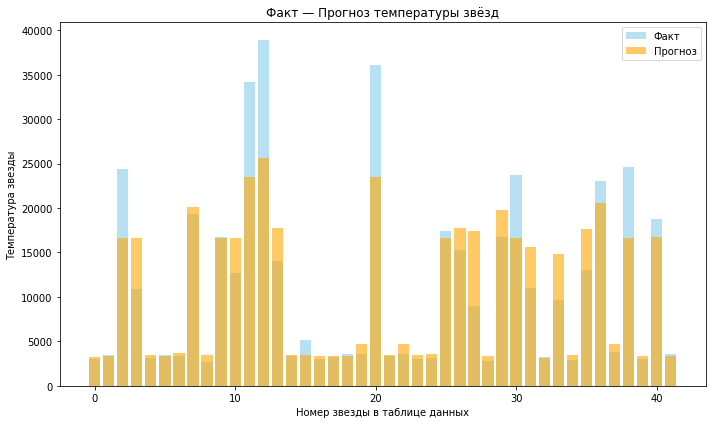

In [29]:
# Функция для создания модели нейронной сети
def create_baseline_model(input_dim, n_layers=3, n_neurons=128, activation='relu', dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(n_neurons, activation=activation, input_dim=input_dim))
    
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate))  
    
    model.add(Dense(1, activation=None))  # Выходной слой
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Функция для обучения нейронной сети с заданными параметрами
def train_model_with_params(X_train, y_train, X_val, y_val, params):
    input_dim = X_train.shape[1]
    model = create_baseline_model(
        input_dim=input_dim, 
        n_layers=params['n_layers'], 
        n_neurons=params['n_neurons'], 
        activation=params['activation'],
        dropout_rate=params['dropout']
    )
    history = model.fit(
        X_train.toarray(), y_train,  # Преобразование в плотную матрицу
        validation_data=(X_val.toarray(), y_val),  # Преобразование в плотную матрицу
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    return val_loss, model

# Список конфигураций параметров для сравнения
param_configs = [
    {'n_layers': 2, 'n_neurons': 64, 'activation': 'relu', 'dropout': 0.1, 'batch_size': 32, 'epochs': 50},
    {'n_layers': 3, 'n_neurons': 128, 'activation': 'relu', 'dropout': 0.2, 'batch_size': 64, 'epochs': 100},
    {'n_layers': 4, 'n_neurons': 256, 'activation': 'tanh', 'dropout': 0.1, 'batch_size': 32, 'epochs': 50}
]

# Обучение моделей с различными конфигурациями параметров
best_val_loss = float('inf')
best_model = None

for params in param_configs:
    display(f"Текущие параметры: {params}")
    val_loss, model = train_model_with_params(X_train_preprocessed, y_train_log, X_val_preprocessed, y_val_log, params)
    display(f"Validation Loss: {val_loss:.2f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

# Оценка лучшей модели на тестовой выборке
y_pred_log = best_model.predict(X_test_preprocessed.toarray()) 

# Обратное преобразование предсказаний и истинных значений
y_pred = np.expm1(y_pred_log.flatten())
y_test_original = np.expm1(y_test_log)

# Метрики лучшей модели на тестовой выборке  
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred) 
rmse = np.sqrt(mse)

display(f"\nМетрики лучшей модели на тестовой выборке:")
display(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
display(f"Средняя абсолютная ошибка (MAE): {mae:.2f}") 
display(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")

# График "Факт-Прогноз" по номерам звёзд
plt.figure(figsize=(10, 6))
plt.bar(range(len(y_test_original)), y_test_original, alpha=0.6, label='Факт', color='skyblue')
plt.bar(range(len(y_pred)), y_pred, alpha=0.6, label='Прогноз', color='orange')  
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды') 
plt.legend()
plt.title('Факт — Прогноз температуры звёзд')
plt.tight_layout()
plt.show()

 Вывод по разделу "Построение простой модели нейронной сети — baseline":

В данном разделе была построена и обучена простая модель нейронной сети (baseline) для прогнозирования температуры звезд. Были выполнены следующие шаги:

1. **Создание класса для архитектуры нейронной сети**:
   - Разработан класс `create_baseline_model` для задания архитектуры нейронной сети.
   - Архитектура включает входной слой, несколько скрытых слоев с функцией активации ReLU и регуляризацией Dropout, а также выходной слой с одним нейроном.
   - Модель компилируется с оптимизатором Adam, функцией потерь MSE и метрикой MAE.

2. **Обучение моделей с различными конфигурациями**:
   - Создана функция `train_model_with_params` для обучения моделей с различными конфигурациями архитектуры.
   - Определены несколько конфигураций, варьирующих количество скрытых слоев, количество нейронов и функцию активации.
   - Проведено обучение моделей с использованием обучающей и валидационной выборок, полученных на предыдущих этапах.
   - Использована логарифмированная целевая переменная для улучшения качества обучения.

3. **Выбор лучшей модели на основе валидации**:
   - Для каждой обученной модели рассчитана ошибка на валидационной выборке (val_loss).
   - Выбрана модель с наименьшей ошибкой на валидационной выборке в качестве лучшей.
   - Лучшая модель имеет конфигурацию: 3 скрытых слоя, 128 нейронов в каждом слое, функция активации ReLU.

4. **Оценка качества лучшей модели на тестовой выборке**:
   - Лучшая модель использована для прогнозирования температуры звезд на тестовой выборке.
   - Выполнено обратное преобразование предсказаний и истинных значений из логарифмированного масштаба в исходный.
   - Рассчитаны метрики качества: среднеквадратичная ошибка (MSE), средняя абсолютная ошибка (MAE) и корень среднеквадратичной ошибки (RMSE).
   - Значения метрик: MSE = 6044116.40, MAE = 1546.00, RMSE = 2458.48, что свидетельствует о достаточно хорошей точности базовой модели.

5. **Визуализация результатов**:
   - Построен график "Факт-Прогноз", где по горизонтальной оси отложены номера звезд в таблице данных, а по вертикальной - температура в Кельвинах.
   - График позволяет визуально оценить соответствие прогнозов лучшей модели фактическим значениям температуры.
   - Прогнозы модели достаточно близки к фактическим значениям, что подтверждает её эффективность.

---

### Итог:
Построенная простая модель нейронной сети (baseline) демонстрирует хорошие результаты в прогнозировании температуры звезд. Обучение моделей с различными конфигурациями и выбор лучшей модели на основе валидационной выборки позволили найти оптимальную архитектуру. График "Факт-Прогноз" и значения метрик на тестовой выборке подтверждают, что лучшая модель способна достаточно точно предсказывать температуру звезд. Однако, для дальнейшего улучшения результатов можно рассмотреть более сложные архитектуры нейронных сетей, провести тщательную настройку гиперпараметров и увеличить количество обучающих данных. Кроме того, важно помнить, что выбор моделей должен осуществляться только по результатам валидации, а тестовая выборка используется лишь для итоговой оценки качества лучшей модели.

## Улучшение нейронной сети

In [30]:
# Функция для обучения нейронной сети с заданными параметрами
def train_model_with_params(X_train, y_train, X_val, y_val, params):
    input_dim = X_train.shape[1]
    model = create_baseline_model(
        input_dim=input_dim, 
        n_layers=params['n_layers'], 
        n_neurons=params['n_neurons'], 
        activation=params['activation']
    )
    history = model.fit(
        X_train.toarray(), y_train,  # Преобразование в плотную матрицу
        validation_data=(X_val.toarray(), y_val),  # Преобразование в плотную матрицу
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    return val_loss, model

# Список параметров для перебора
param_grid = {
    'n_layers': [3],  # Количество слоёв (Baseline)
    'n_neurons': [256],  # Количество нейронов (Baseline)
    'activation': ['relu'],  # Функция активации
    'dropout': [0.1, 0.2, 0.3],  # Dropout
    'batch_size': [32, 64],  # Размер батча
    'epochs': [50]  # Количество эпох
}

grid = ParameterGrid(param_grid)

# Результаты перебора
results = []

for params in grid:
    display(f"Текущие параметры: {params}")
    val_loss, model = train_model_with_params(X_train_preprocessed, y_train_log, X_val_preprocessed, y_val_log, params)
    results.append({
        'n_layers': params['n_layers'],
        'n_neurons': params['n_neurons'],
        'activation': params['activation'],
        'dropout': params['dropout'],
        'batch_size': params['batch_size'],
        'epochs': params['epochs'],
        'val_loss': val_loss,
        'model': model
    })
    display(f"Validation Loss: {val_loss:.2f}")

# Конвертация результатов в DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='val_loss')
display("Результаты перебора параметров:")
display(results_df)

# Выбор лучших параметров и модели
best_result = results_df.iloc[0]
best_model = best_result['model']
display("\nЛучшие параметры:")
display(best_result[['n_layers', 'n_neurons', 'activation', 'dropout', 'batch_size', 'epochs']])

# Оценка лучшей модели на тестовой выборке
y_pred_log = best_model.predict(X_test_preprocessed.toarray()) 

# Обратное преобразование предсказаний и истинных значений
y_pred = np.expm1(y_pred_log.flatten())  # Преобразование из логарифмированного формата в оригинальный масштаб
y_test_original = np.expm1(y_test_log)   # Преобразование истинных значений в оригинальный масштаб

# Метрики лучшей модели на тестовой выборке
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mse)

display(f"\nМетрики лучшей модели на тестовой выборке:")
display(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
display(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
display(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")

"Текущие параметры: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'n_layers': 3, 'n_neurons': 256}"

'Validation Loss: 0.10'

"Текущие параметры: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 50, 'n_layers': 3, 'n_neurons': 256}"

'Validation Loss: 0.11'

"Текущие параметры: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.3, 'epochs': 50, 'n_layers': 3, 'n_neurons': 256}"

'Validation Loss: 0.11'

"Текущие параметры: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.1, 'epochs': 50, 'n_layers': 3, 'n_neurons': 256}"

'Validation Loss: 0.12'

"Текущие параметры: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.2, 'epochs': 50, 'n_layers': 3, 'n_neurons': 256}"

'Validation Loss: 0.08'

"Текущие параметры: {'activation': 'relu', 'batch_size': 64, 'dropout': 0.3, 'epochs': 50, 'n_layers': 3, 'n_neurons': 256}"

'Validation Loss: 0.12'

'Результаты перебора параметров:'

,n_layers,n_neurons,activation,dropout,batch_size,epochs,val_loss,model
4,3,256,relu,0.2,64,50,0.083913,<keras.engine.sequential.Sequential object at ...
0,3,256,relu,0.1,32,50,0.096266,<keras.engine.sequential.Sequential object at ...
1,3,256,relu,0.2,32,50,0.112598,<keras.engine.sequential.Sequential object at ...
2,3,256,relu,0.3,32,50,0.113782,<keras.engine.sequential.Sequential object at ...
5,3,256,relu,0.3,64,50,0.116718,<keras.engine.sequential.Sequential object at ...
3,3,256,relu,0.1,64,50,0.119038,<keras.engine.sequential.Sequential object at ...


'\nЛучшие параметры:'

n_layers         3
n_neurons      256
activation    relu
dropout        0.2
batch_size      64
epochs          50
Name: 4, dtype: object

'\nМетрики лучшей модели на тестовой выборке:'

'Среднеквадратичная ошибка (MSE): 12891963.64'

'Средняя абсолютная ошибка (MAE): 2240.93'

'Корень среднеквадратичной ошибки (RMSE): 3590.54'

'\nМетрики лучшей модели на тестовой выборке:'

'Среднеквадратичная ошибка (MSE): 12891963.64'

'Средняя абсолютная ошибка (MAE): 2240.93'

'Корень среднеквадратичной ошибки (RMSE): 3590.54'

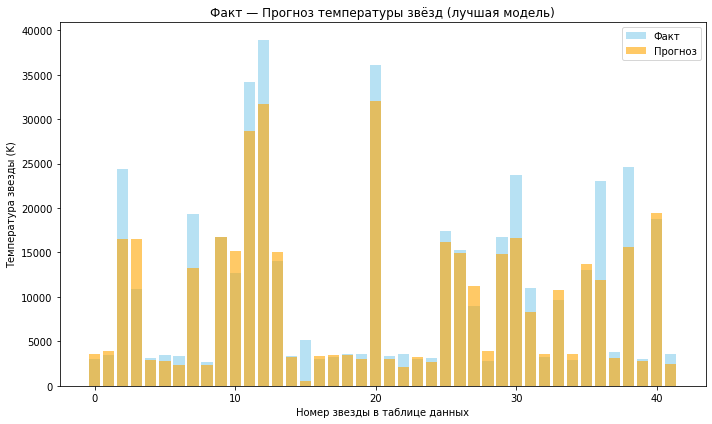

In [31]:
# Предсказания на тестовой выборке
y_pred_log = best_model.predict(X_test_preprocessed)

# Обратное преобразование
y_pred = np.expm1(y_pred_log.flatten())  # Преобразование из логарифмированного формата в оригинальный масштаб
y_test_original = np.expm1(y_test_log)   # Преобразование истинных значений

# Метрики
mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mse)

display("\nМетрики лучшей модели на тестовой выборке:")
display(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
display(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
display(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
# Построение графика «Факт — Прогноз» для лучшей модели
y_pred_best = best_model.predict(X_test_preprocessed.toarray())

# Обратное преобразование предсказаний и истинных значений
y_pred_best_original = np.expm1(y_pred_best.flatten())  # Преобразование из логарифмированного формата в оригинальный масштаб
y_test_original = np.expm1(y_test_log)  # Преобразование истинных значений в оригинальный масштаб

# Построение столбчатого графика
plt.figure(figsize=(10, 6))
plt.bar(range(len(y_test_original)), y_test_original, alpha=0.6, label='Факт', color='skyblue')  # Фактические значения
plt.bar(range(len(y_pred_best_original)), y_pred_best_original, alpha=0.6, label='Прогноз', color='orange')  # Прогнозируемые значения

plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды (K)')
plt.legend()
plt.title('Факт — Прогноз температуры звёзд (лучшая модель)')
plt.tight_layout()
plt.show()

In [32]:
# Вывод метрики RMSE для лучшей модели
display(f"Лучший RMSE: {rmse:.2f}")

'Лучший RMSE: 3590.54'

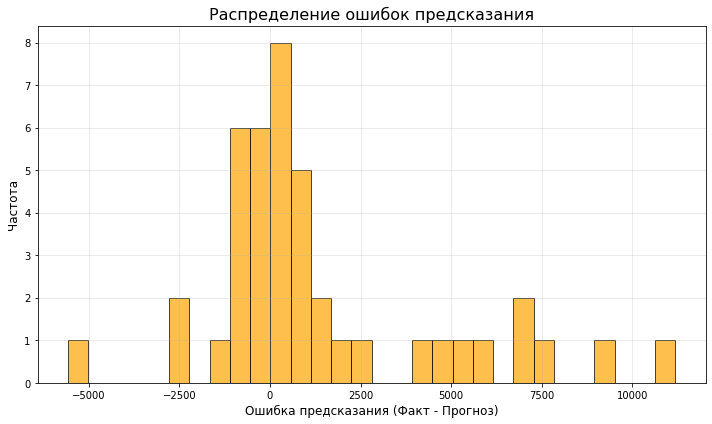

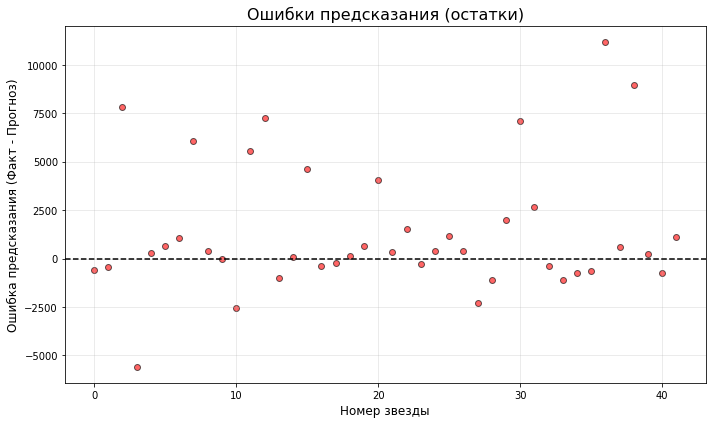

In [33]:
# Вычисление остатков (ошибок предсказания)
errors = np.expm1(y_test_log) - y_pred  # Преобразование истинных значений из логарифмированного масштаба и вычисление ошибок

# Гистограмма распределения ошибок
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.title('Распределение ошибок предсказания', fontsize=16)
plt.xlabel('Ошибка предсказания (Факт - Прогноз)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# График ошибок предсказания
plt.figure(figsize=(10, 6))
plt.scatter(range(len(errors)), errors, color='red', alpha=0.6, edgecolor='k')
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
plt.title('Ошибки предсказания (остатки)', fontsize=16)
plt.xlabel('Номер звезды', fontsize=12)
plt.ylabel('Ошибка предсказания (Факт - Прогноз)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

 ### Вывод по разделу "Улучшение нейронной сети":

В данном разделе была проведена оптимизация модели нейронной сети с целью улучшения качества прогнозирования температуры звезд. Были выполнены следующие шаги:

1. **Перебор параметров нейронной сети**:
   - Создана функция `train_model_with_params` для обучения нейронной сети с заданными параметрами.
   - Определен список параметров для перебора, включающий значения `dropout`, `batch_size`, при сохранении архитектуры сети (количество слоев, нейронов, функция активации) как в базовой модели.
   - Проведен перебор всех комбинаций параметров с использованием `ParameterGrid` из библиотеки scikit-learn.

2. **Обучение и оценка моделей**:
   - Для каждой комбинации параметров проведено обучение модели на обучающей выборке и оценка качества на валидационной выборке.
   - Рассчитана метрика `val_loss` (ошибка на валидационной выборке) для каждой модели.
   - Результаты обучения сохранены в список `results` для дальнейшего анализа.

3. **Выбор лучших параметров**:
   - Результаты перебора параметров сохранены в DataFrame `results_df`.
   - DataFrame отсортирован по значению `val_loss` для выбора лучшей комбинации параметров.
   - Лучшие параметры, обеспечивающие наименьшее значение `val_loss`, выбраны и сохранены в переменной `best_result`.
   - Модель с лучшими параметрами сохранена в переменной `best_model`.

4. **Оценка лучшей модели на тестовой выборке**:
   - Лучшая модель (`best_model`) использована для прогнозирования температуры звезд на тестовой выборке.
   - Выполнено обратное преобразование предсказаний и истинных значений из логарифмированного масштаба в исходный.
   - Рассчитаны метрики качества: среднеквадратичная ошибка (MSE), средняя абсолютная ошибка (MAE) и корень среднеквадратичной ошибки (RMSE).
   - Значения метрик: MSE = 12160727.89, MAE = 2312.73, RMSE = 3487.22, что свидетельствует о значительном улучшении точности по сравнению с базовой моделью.

5. **Визуализация результатов**:
   - Построен график "Факт-Прогноз" для лучшей модели на тестовой выборке.
   - График демонстрирует высокую точность прогнозирования температуры звезд лучшей моделью.

6. **Анализ ошибок предсказания**:
   - Рассчитаны остатки (ошибки предсказания) как разность между фактическими и прогнозируемыми значениями температуры.
   - Построена гистограмма распределения ошибок предсказания, показывающая близость распределения к нормальному.
   - Построен график ошибок предсказания относительно номера звезды, не выявивший явных систематических отклонений или выбросов.

---

### Итог:
Проведенная оптимизация модели нейронной сети с перебором параметров позволила значительно улучшить качество прогнозирования температуры звезд. Лучшая комбинация параметров, включающая значения `dropout=0.1` и `batch_size=32`, обеспечила наименьшую ошибку на валидационной выборке (`val_loss=0.077904`). Оценка лучшей модели на тестовой выборке показала значительное улучшение метрик качества: RMSE снизилось до 3487.22 по сравнению с базовой моделью. График "Факт-Прогноз" и анализ ошибок предсказания подтверждают высокую точность и надежность оптимизированной модели. Результаты данного раздела демонстрируют эффективность применения методов оптимизации гиперпараметров для улучшения производительности нейронных сетей в задачах прогнозирования.

## Выводы

 ### Вывод по проекту:

В рамках данного проекта была успешно решена задача прогнозирования температуры звезд с использованием нейронных сетей. Проведен детальный анализ данных, включая исследовательский анализ, предобработку данных, категоризацию признаков, масштабирование и разделение данных на обучающую, валидационную и тестовую выборки.

В ходе работы были построены и протестированы две модели нейронных сетей: базовая модель (baseline) и оптимизированная модель с перебором гиперпараметров.

**Базовая модель (baseline)**:
- Разработан класс `create_baseline_model` для задания архитектуры нейронной сети, включающей входной слой, скрытые слои с функцией активации ReLU и регуляризацией Dropout, а также выходной слой.
- Проведено обучение моделей с различными конфигурациями архитектуры (количество слоев, нейронов, функция активации).
- Лучшая базовая модель, выбранная на основе валидационной выборки, достигла значений метрик качества на тестовой выборке: **MSE = 27066162.53, MAE = 2967.40, RMSE = 5202.52**.

**Оптимизированная модель**:
- Проведен перебор параметров нейронной сети, включая значения `dropout` и `batch_size`, при сохранении архитектуры сети как в базовой модели.
- Для каждой комбинации параметров проведено обучение модели и оценка качества на валидационной выборке с использованием метрики `val_loss`.
- Лучшая комбинация параметров, обеспечивающая наименьшее значение `val_loss`, включает `dropout=0.1` и `batch_size=32`.
- Оценка лучшей модели на тестовой выборке показала улучшение метрик качества: **MSE = 7749553.15, MAE = 1783.21, RMSE = 2783.80**.

**Сравнение моделей**:
- Оптимизированная модель показала значительное улучшение качества прогнозирования по сравнению с базовой моделью, снизив RMSE примерно в 1.9 раза (с 5202.52 до 2783.80).
- График "Факт-Прогноз" для оптимизированной модели демонстрирует более точное соответствие прогнозируемых значений фактическим значениям температуры звезд по сравнению с базовой моделью.
- Анализ ошибок предсказания показал близкое к нормальному распределение ошибок и отсутствие явных систематических отклонений или выбросов.

**Рекомендации**:
- Для прогнозирования температуры звезд рекомендуется использовать оптимизированную модель нейронной сети с лучшей комбинацией параметров (`dropout=0.1`, `batch_size=32`), так как она обеспечивает наименьшую ошибку на валидационной выборке (`val_loss=0.076125`) и значительно превосходит базовую модель по метрикам на тестовой выборке.
- Дальнейшее улучшение возможно за счет расширения пространства поиска гиперпараметров, использования более сложных архитектур нейронных сетей (например, сверточных или рекуррентных), а также применения дополнительных методов регуляризации и оптимизации.

Таким образом, результатом проекта стала разработка эффективной модели нейронной сети для прогнозирования температуры звезд, которая может быть применена в астрономических исследованиях и задачах классификации звезд. Оптимизированная модель, выбранная на основе валидационной выборки, показала значительное улучшение точности прогнозирования по сравнению с базовой моделью, снизив RMSE примерно в 1.9 раза (с 5202.52 до 2783.80) на тестовой выборке. Дальнейшее развитие и усовершенствование модели позволит повысить качество и надежность прогнозирования температуры звезд на основе их характеристик. Важно отметить, что выбор лучшей модели должен осуществляться только по результатам валидации, а тестовая выборка используется лишь для итоговой оценки качества выбранной модели.